<a href="https://colab.research.google.com/github/Nancy-Shi/Complex_Networks/blob/main/061523_SIS_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import math as math
from math import log

In [140]:
def build_adjacency_list(edges):
    G = nx.Graph()
    G.add_edges_from(edges)

    adjacency_list = {}
    index_list = {}
    neighbor_list = []
    neighbor_count = {}  # New dictionary to store the number of neighbors for each node

    index = 0
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        adjacency_list[node] = neighbors
        neighbor_list.extend(neighbors)

        neighbor_count[node] = len(neighbors)  # Store the number of neighbors for the node

        # Create index list with the node and its starting position
        index_list[node] = index
        index += len(neighbors)

    return adjacency_list, index_list, neighbor_list, neighbor_count

def print_adjacency_list(edges):
    adj_list, index_list, neighbor_list, neighbor_count = build_adjacency_list(edges)

    print("Adjacency List:")
    for node, neighbors in adj_list.items():
        print(f"Node {node}: {neighbors}")

    print("\nNeighbor List:")
    print(neighbor_list)

    print("\nIndex List:")
    for node, start_index in index_list.items():
        print(f"{node}: {start_index}")

    print("\nNeighbor Count:")
    for node, count in neighbor_count.items():
        print(f"{node}: {count}")

In [141]:
## Build my own configuration model
def generate_degree_sequence(n, gamma, kmin):
    """
    Generates a degree sequence of length n following a power law distribution.

    Parameters:
        n (int): Length of the degree sequence.
        gamma (float): Exponent of the power law distribution (gamma > 1).
        kmin (int): Minimum degree value in the sequence.

    Returns:
        list: Degree sequence following a power law distribution.
    """

    # Generate a random sample from the power law distribution
    # by mapping the uniform distribution to power law distribution
    u = np.random.uniform(size=n)
    degrees = np.ceil((1.0 - u) ** (-1.0 / (gamma - 1.0)))

    # Adjust degrees based on the minimum and maximum degree values (kmin, kmax)
    kmax = int(math.sqrt(n))
    degrees = [int(degree) for degree in degrees if degree >= kmin and degree <= kmax]

    # Truncate or pad the sequence to match the desired length
    degrees = degrees[:n] if len(degrees) >= n else degrees + [kmin] * (n - len(degrees))

    return degrees

In [142]:
def generate_configuration_model(degree_sequence):
    """
    Generates a random graph based on the input of a degree sequence
    It checks if the sum of degrees is odd.
    There should be no double connections and no self connections.

    """
    # Create an empty graph
    G = nx.Graph()

    # Calculate the sum of degrees
    degree_sum = sum(degree_sequence)

    # Print error message if the sum is odd
    if degree_sum % 2 != 0:
        raise ValueError("Degree sum is odd")


    # Create a list of labels based on the degree sequence
    labels = []
    for node, degree in enumerate(degree_sequence):
        labels.extend([node] * degree)
    #print(labels)

    # Randomly shuffle the labels
    random.shuffle(labels)

    # Pair the lables and add edges to the graph
    # check to ensure no link to self
    # do not add edge if it's already in graph

    while len(labels) >= 2:  # At least two labels are required to form an edge
        node1 = labels[-1]
        node2 = labels[-2]
        if node1 != node2 and not G.has_edge(node1, node2):
            G.add_edge(node1, node2)
            labels.pop()
            labels.pop()
        else:
            random.shuffle(labels)

    return G

In [143]:
from networkx.algorithms.flow.networksimplex import not_implemented_for
def assign_disease_states(G, frac_inf):
    """
     Randomly assigns disease states to nodes in a given graph,
     stores the states in an array,
     and creates another array to store the list of infected nodes.
    """
    N = len(G.nodes())
    N_inf = int(N * frac_inf)

    nodes = list(G.nodes())
    random.shuffle(nodes)

    infected_nodes = nodes[:N_inf]
    states = {node: 1 if node in infected_nodes else 0 for node in G}

    print("Disease states:", states)
    print("Infected nodes:", infected_nodes)

    return states, infected_nodes

def color_graph_nodes(states, G):
    """
    Takes the disease states array and graph as input,
    and plot the graph with green color for susceptible nodes
    and red color for infected nodes.
    """
    susceptible_nodes = [node for node, state in states.items() if state == 0]
    infected_nodes = [node for node, state in states.items() if state == 1]
    node_colors = ['green' if node in susceptible_nodes else 'red' for node in G.nodes()]
    nx.draw(G, with_labels=True, node_color=node_colors)
    plt.show()

Degree sequence: [(1, 3), (3, 3), (6, 3), (9, 3), (7, 3), (4, 3), (2, 3), (0, 3), (8, 3), (5, 3)]


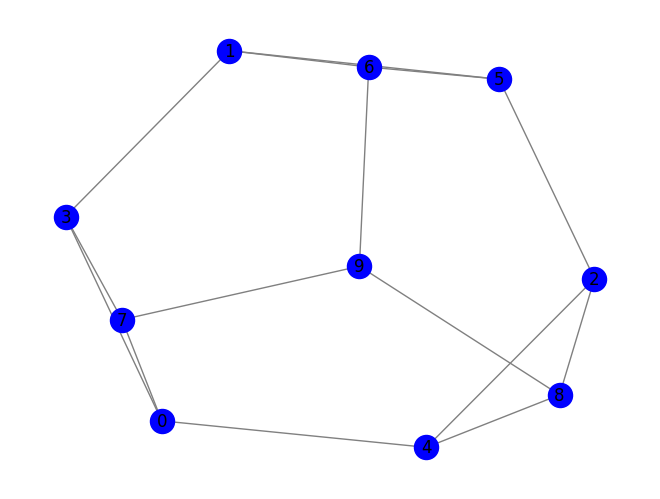

Disease states: {1: 0, 3: 0, 6: 0, 9: 1, 7: 0, 4: 0, 2: 0, 0: 0, 8: 0, 5: 1}
Infected nodes: [5, 9]


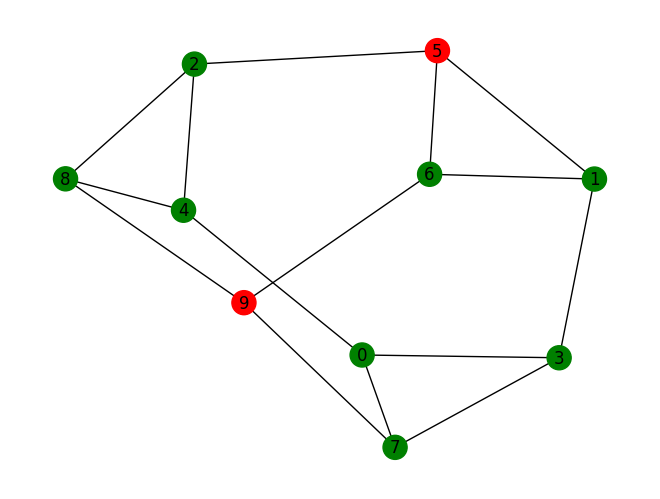

In [144]:
# Test
degree_sequence = generate_degree_sequence(10, 4, 3)

G = generate_configuration_model(degree_sequence)

# Print the resulting graph's degree sequence
print("Degree sequence:", list(G.degree()))

# draw the graph
nx.draw(G, node_color="blue", edge_color="grey", width=1, with_labels=True)
plt.show()

# assign disease states and color infected or susceptible
states, infected_nodes = assign_disease_states(G, 0.2)
color_graph_nodes(states, G)

In [145]:
def count_infection(states,G):
    """
    Ninf counts the number of infected individuals
    Ne counts the edges connecting "I"
    """
    infected_nodes = [node for node, state in states.items() if state == 1]
    Ninf = len(infected_nodes)

    Ne = sum(G.degree(node) for node in infected_nodes)

    print("Number of infected:", Ninf)
    print("Number of edges connected to infected:", Ne)

    return Ninf, Ne

In [146]:
# Test:
count_infection(states,G)

Number of infected: 2
Number of edges connected to infected: 6


(2, 6)

In [147]:
def SIS_simulation(states, G, lambda1, mu1):
    """
    Input: disease states, network, transmission rate (lambda1), recovery rate (mu1)
    Test Output: p, acceptance probability array
    Output: updated disease states, network
    """
    Ninf, Ne = count_infection(states,G)
    p = (mu1 * Ninf)/(mu1 * Ninf+ lambda1 * Ne)

    q = {} # array to store acceptance probability of an infection node is chosen to be infected
    kmax = max(G.degree(node) for node in infected_nodes)

    for node in infected_nodes:
      q[node] = G.degree(node)/kmax

    return p, q

In [148]:
SIS_simulation(states, G, 0.4, 0.2)

Number of infected: 2
Number of edges connected to infected: 6


(0.14285714285714285, {5: 1.0, 9: 1.0})

In [153]:
def OGA_SIS(initial_states, infected_nodes, graph, mu, lam, states):

    N_inf, N_e = count_infection(initial_states, graph)

    while True:
        R = mu * N_inf + lam * N_e

        if R == 0:
            break

        tau = -math.log(random.uniform(0, 1)) / R

        if tau <= 0:
            break

        node = random.choice(infected_nodes)

        p = (mu * N_inf) / R

        if random.uniform(0, 1) < p:
            states[node] = 0
        else:
            neighbors = [neighbor for neighbor in graph[node] if states[neighbor] == 0]
            if neighbors:
                selected_neighbor = random.choice(neighbors)
                states[selected_neighbor] = 1

        infected_nodes = [node for node, state in states.items() if state == 1]

    print("Final disease states:", states)

    return states

Disease states: {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 1, 27: 1, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0}
Infected nodes: [3, 26, 27]


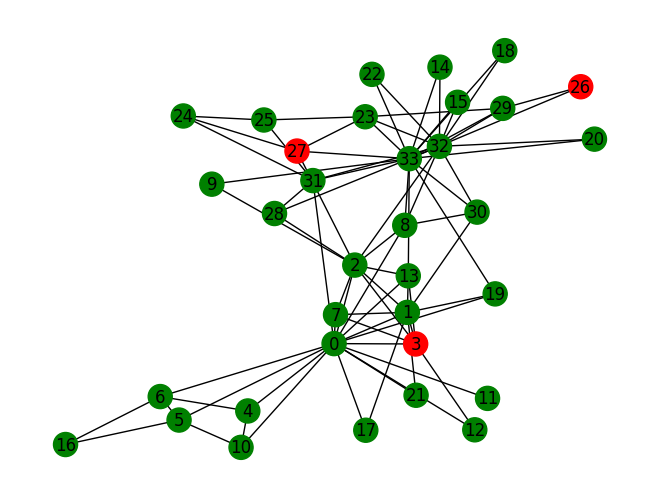

In [157]:
G2 = nx.karate_club_graph()
states2, infected_nodes2 = assign_disease_states(G2, 0.1)
color_graph_nodes(states2, G2)
#OGA_SIS(states2, infected_nodes2, G2, 0.3, 0.2, states2.copy())